# Проект 6. Обучение с учителем

## Прогноз оттока клиентов из банка
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

проект считается 13 минут.

# 1. Подготовка данных

Импортируем исходный датасет и необходимые модели, метрики

In [49]:
import time
start = time.time()

In [85]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
#from sklearn.inspection import permutation_importance

#df = pd.read_csv('/Users/artemsivtsov/Downloads/Churn.csv') #'/datasets/Churn.csv')
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [86]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
rownumber          10000 non-null int64
customerid         10000 non-null int64
surname            10000 non-null object
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             9091 non-null float64
balance            10000 non-null float64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null float64
exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [35]:
df = df.dropna(axis=0).reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 15 columns):
index              9091 non-null int64
rownumber          9091 non-null int64
customerid         9091 non-null int64
surname            9091 non-null object
creditscore        9091 non-null int64
geography          9091 non-null object
gender             9091 non-null object
age                9091 non-null int64
tenure             9091 non-null float64
balance            9091 non-null float64
numofproducts      9091 non-null int64
hascrcard          9091 non-null int64
isactivemember     9091 non-null int64
estimatedsalary    9091 non-null float64
exited             9091 non-null int64
dtypes: float64(3), int64(9), object(3)
memory usage: 1.0+ MB


удаляем строки с пропусками, так как я не придумал как можно заменить их по логике. Да и вряд ли можно достоверно заменить количество недвижимости. Процент пропусков немногим менее 10%, что достаточно много, но не криитчно.

In [36]:
#df = df.drop(['index', 'rownumber', 'customerid'], axis='columns')

In [89]:
df = df.drop(['rownumber', 'customerid', 'surname'], axis='columns')

In [90]:
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## Вывод
Была выполнена предобработка данных, данные готовы к моделированию.

In [91]:
# будем проводить категоризацию только категориям
categorical = ['geography', 'gender']

# 2. Исследование задачи

In [92]:
#df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe = pd.get_dummies(df, drop_first=True, columns=categorical)   # НОВАЯ СТРОКА С КОДОМ

target = df_ohe['exited']
features = df_ohe.drop(['exited', 'tenure'], axis=1)

features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

print(features_train.shape)
print(target_train.shape)

print(features_valid.shape)
print(target_valid.shape)

print(features_test.shape)
print(target_test.shape)

(6000, 10)
(6000,)
(2000, 10)
(2000,)
(2000, 10)
(2000,)


In [45]:
features_train.head(3)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
8483,727,28,2.0,110997.76,1,1,0,101433.76,0,0,0
3431,537,26,7.0,106397.75,1,0,0,103563.23,0,0,1
6770,610,40,9.0,0.00,1,1,1,149602.54,0,0,1


Кодируем данные с помощью ОНЕ, т.к. категориальные признаки необходимо привести к численному виду. Разделяем наши данные на тренировочную, валидационную и тестовую выборку в соотношении 60, 20, 20 %.

<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
метод категоризации с удалением лишнего столбца - ОК.<br>
Тут ещё можно контролировать размер новых выборок

Попробуем пару моделей без перебора гиперпараметров:

In [84]:
model_log = LogisticRegression(random_state=12345, solver='liblinear')
model_log.fit(features_train, target_train)
predicted_valid_log = pd.Series(model_log.predict(features_valid))

print('accuracy =', accuracy_score(target_valid, predicted_valid_log))
print('precision =', precision_score(target_valid, predicted_valid_log))
print('recall =', recall_score(target_valid, predicted_valid_log))
print('f1 =', f1_score(target_valid, predicted_valid_log))
probabilities_valid_log = model_log.predict_proba(features_valid)
probabilities_one_valid_log = probabilities_valid_log[:, 1]
print('roc_auc =', roc_auc_score(target_valid, probabilities_one_valid_log))

accuracy = 0.8102310231023102
precision = 0.6333333333333333
recall = 0.20159151193633953
f1 = 0.30583501006036223
roc_auc = 0.7728699308062298


In [47]:
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_train, target_train)
predicted_valid_tree = pd.Series(model_tree.predict(features_valid))

print('accuracy =', accuracy_score(target_valid, predicted_valid_tree))
print('precision =', precision_score(target_valid, predicted_valid_tree))
print('recall =', recall_score(target_valid, predicted_valid_tree))
print('f1 =', f1_score(target_valid, predicted_valid_tree))
probabilities_valid_tree = model_tree.predict_proba(features_valid)
probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
print('roc_auc =', roc_auc_score(target_valid, probabilities_one_valid_tree))

accuracy = 0.7898789878987899
precision = 0.49333333333333335
recall = 0.4907161803713528
f1 = 0.4920212765957447
roc_auc = 0.679431650213435


In [48]:
model_forest = RandomForestClassifier(random_state=12345)
model_forest.fit(features_train, target_train)
predicted_valid_forest = pd.Series(model_forest.predict(features_valid))

print('accuracy =', accuracy_score(target_valid, predicted_valid_forest))
print('precision =', precision_score(target_valid, predicted_valid_forest))
print('recall =', recall_score(target_valid, predicted_valid_forest))
print('f1 =',f1_score(target_valid, predicted_valid_forest))

probabilities_valid_forest = model_forest.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
print('roc_auc =', roc_auc_score(target_valid, probabilities_one_valid_forest))

accuracy = 0.8503850385038504
precision = 0.7397260273972602
recall = 0.4297082228116711
f1 = 0.5436241610738256
roc_auc = 0.8348221928111372


Результаты не впечатляющие.. Продолжим обработку

In [49]:
numeric = ['creditscore', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']

#scaler = StandardScaler()
#scaler.fit(features_train[numeric])
#features_train[numeric] = scaler.transform(features_train[numeric])
#features_valid[numeric] = scaler.transform(features_valid[numeric])

In [80]:

scaler = StandardScaler()
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])


Масштабируем количественные признаки с помощью скейлера и пробуем на простых моделях еще раз:

In [81]:
model_log = LogisticRegression(random_state=12345, solver='liblinear')
model_log.fit(features_train, target_train)
predicted_valid_log = pd.Series(model_log.predict(features_valid))

print('accuracy =', accuracy_score(target_valid, predicted_valid_log))
print('precision =', precision_score(target_valid, predicted_valid_log))
print('recall =', recall_score(target_valid, predicted_valid_log))
print('f1 =', f1_score(target_valid, predicted_valid_log))
probabilities_valid_log = model_log.predict_proba(features_valid)
probabilities_one_valid_log = probabilities_valid_log[:, 1]
print('roc_auc =', roc_auc_score(target_valid, probabilities_one_valid_log))

accuracy = 0.8102310231023102
precision = 0.6333333333333333
recall = 0.20159151193633953
f1 = 0.30583501006036223
roc_auc = 0.7728699308062298


In [82]:
%%time
best_model_tree = None
best_depth_tree = 0
best_acc_tree = 0
best_prec_tree = 0
best_rec_tree = 0
best_f1_tree = 0
best_roc_auc_tree = 0
for depth in range(1, 20, 1):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)
    predicted_valid_tree = pd.Series(model_tree.predict(features_valid))
    result_tree = f1_score(target_valid, predicted_valid_tree)
    if result_tree > best_f1_tree:
        best_model_tree = model_tree
        best_depth_tree = depth
        best_acc_tree = accuracy_score(target_valid, predicted_valid_tree)
        best_prec_tree = precision_score(target_valid, predicted_valid_tree)
        best_rec_tree = recall_score(target_valid, predicted_valid_tree)
        best_f1_tree = result_tree
        probabilities_valid_tree = model_tree.predict_proba(features_valid)
        probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
        best_roc_auc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)

print('Depth наилучшей модели:', best_depth_tree)
print("Accuracy на валидационной выборке:", best_acc_tree)
print("Precision на валидационной выборке:", best_prec_tree)
print("Recall на валидационной выборке:", best_rec_tree)        
print("F1 на валидационной выборке:", best_f1_tree)
print("ROC_AUC на валидационной выборке:", best_roc_auc_tree)

Depth наилучшей модели: 7
Accuracy на валидационной выборке: 0.8536853685368537
Precision на валидационной выборке: 0.7211155378486056
Recall на валидационной выборке: 0.48010610079575594
F1 на валидационной выборке: 0.5764331210191083
ROC_AUC на валидационной выборке: 0.8346049843812412
CPU times: user 474 ms, sys: 111 µs, total: 474 ms
Wall time: 472 ms


Наилучшее значение метрики Ф1 получилось при глубине дерева 7. Ф1=0.58, что близко к целевому значению.

In [53]:
%%time
best_model_forest = None
best_depth_forest = 0
best_n_est = 0
best_acc_forest = 0
best_prec_forest = 0
best_rec_forest = 0
best_f1_forest = 0
best_roc_auc_forest = 0
for depth in range(1, 20, 1):
    for n in range(1, 100, 5):
        model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n)
        model_forest.fit(features_train, target_train)
        predicted_valid_forest = pd.Series(model_tree.predict(features_valid))
        result_forest = f1_score(target_valid, predicted_valid_forest)
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_depth_forest = depth
            best_n_est = n
            best_acc_forest = accuracy_score(target_valid, predicted_valid_forest)
            best_prec_forest = precision_score(target_valid, predicted_valid_forest)
            best_rec_forest = recall_score(target_valid, predicted_valid_forest)
            best_f1_forest = result_forest
            probabilities_valid_forest = model_forest.predict_proba(features_valid)
            probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
            best_roc_auc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)

print('Depth наилучшей модели:', best_depth_forest)
print('N_estimators наилучшей модели:', best_n_est)
print("Accuracy на валидационной выборке:", best_acc_forest)
print("Precision на валидационной выборке:", best_prec_forest)
print("Recall на валидационной выборке:", best_rec_forest)        
print("F1 на валидационной выборке:", best_f1_forest)
print("ROC_AUC на валидационной выборке:", best_roc_auc_forest)

Depth наилучшей модели: 1
N_estimators наилучшей модели: 1
Accuracy на валидационной выборке: 0.7854785478547854
Precision на валидационной выборке: 0.4830287206266319
Recall на валидационной выборке: 0.4907161803713528
F1 на валидационной выборке: 0.48684210526315796
ROC_AUC на валидационной выборке: 0.5731679481350448
CPU times: user 1min 50s, sys: 224 ms, total: 1min 50s
Wall time: 2min 13s


## Вывод
были исследованы данные и модели, проведено кодирование и масштабирование, однако целевого значения Ф1 не удалось достичь. Лучшее значение - 0.58 у модели дерева решений с глубиной 7.

# 3. Борьба с дисбалансом

Исследуем дисбаланс на нашем целевом признаке:

In [54]:
class_frequency = df['exited'].value_counts(normalize=True)
class_frequency

0    0.796062
1    0.203938
Name: exited, dtype: float64

соотношение 0 и 1 примерно 80 на 20, значит необходима балансировка.

In [55]:
class_frequency_pred_log = predicted_valid_log.value_counts(normalize=True)
class_frequency_pred_log

0    0.933993
1    0.066007
dtype: float64

In [56]:
class_frequency_pred_tree = predicted_valid_tree.value_counts(normalize=True)
class_frequency_pred_tree

0    0.789329
1    0.210671
dtype: float64

In [57]:
class_frequency_pred_forest = predicted_valid_forest.value_counts(normalize=True)
class_frequency_pred_forest

0    0.789329
1    0.210671
dtype: float64

Соотношение у моделей и того гораздо хуже

## class_weight='balanced'

Теперь попробуем наши данные прогнать через модели со взвешиванием классов ( с балансировкой)

In [58]:
model_log = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_log.fit(features_train, target_train)
predicted_valid_log = pd.Series(model_log.predict(features_valid))

print('accuracy =', accuracy_score(target_valid, predicted_valid_log))
print('precision =', precision_score(target_valid, predicted_valid_log))
print('recall =', recall_score(target_valid, predicted_valid_log))
print('f1 =', f1_score(target_valid, predicted_valid_log))
probabilities_valid_log = model_log.predict_proba(features_valid)
probabilities_one_valid_log = probabilities_valid_log[:, 1]
print('roc_auc =', roc_auc_score(target_valid, probabilities_one_valid_log))

accuracy = 0.7084708470847084
precision = 0.39148936170212767
recall = 0.7320954907161804
f1 = 0.5101663585951941
roc_auc = 0.777565682540676


In [59]:
%%time
best_model_tree = None
best_depth_tree = 0
best_acc_tree = 0
best_prec_tree = 0
best_rec_tree = 0
best_f1_tree = 0
best_roc_auc_tree = 0
for depth in range(1, 20, 1):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_tree.fit(features_train, target_train)
    predicted_valid_tree = pd.Series(model_tree.predict(features_valid))
    result_tree = f1_score(target_valid, predicted_valid_tree)
    if result_tree > best_f1_tree:
        best_model_tree = model_tree
        best_depth_tree = depth
        best_acc_tree = accuracy_score(target_valid, predicted_valid_tree)
        best_prec_tree = precision_score(target_valid, predicted_valid_tree)
        best_rec_tree = recall_score(target_valid, predicted_valid_tree)
        best_f1_tree = result_tree
        probabilities_valid_tree = model_tree.predict_proba(features_valid)
        probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
        best_roc_auc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)

print('Depth наилучшей модели:', best_depth_tree)
print("Accuracy на валидационной выборке:", best_acc_tree)
print("Precision на валидационной выборке:", best_prec_tree)
print("Recall на валидационной выборке:", best_rec_tree)        
print("F1 на валидационной выборке:", best_f1_tree)
print("ROC_AUC на валидационной выборке:", best_roc_auc_tree)

Depth наилучшей модели: 5
Accuracy на валидационной выборке: 0.7783278327832783
Precision на валидационной выборке: 0.477112676056338
Recall на валидационной выборке: 0.7188328912466844
F1 на валидационной выборке: 0.5735449735449736
ROC_AUC на валидационной выборке: 0.8396523192522141
CPU times: user 721 ms, sys: 101 µs, total: 721 ms
Wall time: 1.44 s


In [60]:
%%time
best_model_forest = None
best_depth_forest = 0
best_n_est = 0
best_acc_forest = 0
best_prec_forest = 0
best_rec_forest = 0
best_f1_forest = 0
best_roc_auc_forest = 0
for depth in range(1, 20, 1):
    for n in range(1, 100, 5):
        model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n, 
                                              class_weight='balanced')
        model_forest.fit(features_train, target_train)
        predicted_valid_forest = pd.Series(model_tree.predict(features_valid))
        result_forest = f1_score(target_valid, predicted_valid_forest)
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_depth_forest = depth
            best_n_est = n
            best_acc_forest = accuracy_score(target_valid, predicted_valid_forest)
            best_prec_forest = precision_score(target_valid, predicted_valid_forest)
            best_rec_forest = recall_score(target_valid, predicted_valid_forest)
            best_f1_forest = result_forest
            probabilities_valid_forest = model_forest.predict_proba(features_valid)
            probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
            best_roc_auc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)

print('Depth наилучшей модели:', best_depth_forest)
print('N_estimators наилучшей модели:', best_n_est)
print("Accuracy на валидационной выборке:", best_acc_forest)
print("Precision на валидационной выборке:", best_prec_forest)
print("Recall на валидационной выборке:", best_rec_forest)        
print("F1 на валидационной выборке:", best_f1_forest)
print("ROC_AUC на валидационной выборке:", best_roc_auc_forest)

Depth наилучшей модели: 1
N_estimators наилучшей модели: 1
Accuracy на валидационной выборке: 0.7843784378437844
Precision на валидационной выборке: 0.4789915966386555
Recall на валидационной выборке: 0.4535809018567639
F1 на валидационной выборке: 0.46594005449591286
ROC_AUC на валидационной выборке: 0.5731679481350448
CPU times: user 1min 57s, sys: 384 ms, total: 1min 57s
Wall time: 3min 59s


## вывод
Лучшее значение получилось снова у дерева решений при глубине 5, значение Ф1 = 0.57

## upsample

Попробуем отбалансировать наши признаки с помощью апсемплинга. Использовано значение 4, т.к. признаков 0 в 4 раза больше чем 1, следовательно необходимо число 1 увеличить в 4 раза

In [61]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [62]:
%%time
best_model_tree = None
best_depth_tree = 0
best_acc_tree = 0
best_prec_tree = 0
best_rec_tree = 0
best_f1_tree = 0
best_roc_auc_tree = 0
for depth in range(1, 20, 1):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_upsampled, target_upsampled)
    predicted_valid_tree = pd.Series(model_tree.predict(features_valid))
    predicted_train_tree = pd.Series(model_tree.predict(features_train))
    result_tree = f1_score(target_valid, predicted_valid_tree)
    if result_tree > best_f1_tree:
        best_model_tree = model_tree
        best_depth_tree = depth
        best_acc_tree = accuracy_score(target_valid, predicted_valid_tree)
        best_prec_tree = precision_score(target_valid, predicted_valid_tree)
        best_rec_tree = recall_score(target_valid, predicted_valid_tree)
        best_f1_tree = result_tree
        probabilities_valid_tree = model_tree.predict_proba(features_valid)
        probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
        best_roc_auc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)


print('Depth наилучшей модели:', best_depth_tree)        

print("Accuracy на тренировочной выборке:", accuracy_score(target_train, predicted_train_tree))
print("Precision на тренировочной выборке:", precision_score(target_train, predicted_train_tree))
print("Recall на тренировочной выборке:", recall_score(target_train, predicted_train_tree))        
print("F1 на тренировочной выборке:", f1_score(target_train, predicted_train_tree))
        
print()
print("Accuracy на валидационной выборке:", best_acc_tree)
print("Precision на валидационной выборке:", best_prec_tree)
print("Recall на валидационной выборке:", best_rec_tree)        
print("F1 на валидационной выборке:", best_f1_tree)
print("ROC_AUC на валидационной выборке:", best_roc_auc_tree)
print()

Depth наилучшей модели: 5
Accuracy на тренировочной выборке: 0.9966996699669967
Precision на тренировочной выборке: 0.9842657342657343
Recall на тренировочной выборке: 1.0
F1 на тренировочной выборке: 0.9920704845814978

Accuracy на валидационной выборке: 0.7783278327832783
Precision на валидационной выборке: 0.477112676056338
Recall на валидационной выборке: 0.7188328912466844
F1 на валидационной выборке: 0.5735449735449736
ROC_AUC на валидационной выборке: 0.8396523192522141

CPU times: user 731 ms, sys: 235 µs, total: 731 ms
Wall time: 1.43 s


In [63]:
%%time
best_model_forest = None
best_depth_forest = 0
best_n_est = 0
best_acc_forest = 0
best_prec_forest = 0
best_rec_forest = 0
best_f1_forest = 0
best_roc_auc_forest = 0
for depth in range(1, 20, 1):
    for n in range(1, 100, 5):
        model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n)
        model_forest.fit(features_upsampled, target_upsampled)
        predicted_valid_forest = pd.Series(model_tree.predict(features_valid))
        result_forest = f1_score(target_valid, predicted_valid_forest)
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_depth_forest = depth
            best_n_est = n
            best_acc_forest = accuracy_score(target_valid, predicted_valid_forest)
            best_prec_forest = precision_score(target_valid, predicted_valid_forest)
            best_rec_forest = recall_score(target_valid, predicted_valid_forest)
            best_f1_forest = result_forest
            probabilities_valid_forest = model_forest.predict_proba(features_valid)
            probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
            best_roc_auc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)

print('Depth наилучшей модели:', best_depth_forest)
print('N_estimators наилучшей модели:', best_n_est)
print("Accuracy на валидационной выборке:", best_acc_forest)
print("Precision на валидационной выборке:", best_prec_forest)
print("Recall на валидационной выборке:", best_rec_forest)        
print("F1 на валидационной выборке:", best_f1_forest)
print("ROC_AUC на валидационной выборке:", best_roc_auc_forest)

Depth наилучшей модели: 1
N_estimators наилучшей модели: 1
Accuracy на валидационной выборке: 0.7805280528052805
Precision на валидационной выборке: 0.4696132596685083
Recall на валидационной выборке: 0.4509283819628647
F1 на валидационной выборке: 0.4600811907983762
ROC_AUC на валидационной выборке: 0.5957410580995735
CPU times: user 2min 51s, sys: 363 ms, total: 2min 52s
Wall time: 5min 50s


## вывод
наиболее "успешной" моделью с лучшим значением метрики F1 является модель дерева решений с глубиной 5, однако ф1 имеет значение всего 0.574.

# Downsample

Попробуем даунсемпл. Используем фрак=0.25, т.к. 25% от 80% 0 в нашем балансе это 0.2. То есть таким образом мы долю 0 уменьшим в 4 раза.

In [64]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [65]:
model_log = LogisticRegression(random_state=12345, solver='liblinear')
model_log.fit(features_downsampled, target_downsampled)
predicted_valid_log = model_log.predict(features_valid)

print('accuracy =', accuracy_score(target_valid, predicted_valid_log))
print('precision =', precision_score(target_valid, predicted_valid_log))
print('recall =', recall_score(target_valid, predicted_valid_log))
print('f1 =', f1_score(target_valid, predicted_valid_log))
probabilities_valid_log = model_log.predict_proba(features_valid)
probabilities_one_valid_log = probabilities_valid_log[:, 1]
print('roc_auc =', roc_auc_score(target_valid, probabilities_one_valid_log))

accuracy = 0.6958195819581958
precision = 0.3810810810810811
recall = 0.7480106100795756
f1 = 0.5049239033124441
roc_auc = 0.7761630314933816


In [66]:
%%time
best_model_tree = None
best_depth_tree = 0
best_acc_tree = 0
best_prec_tree = 0
best_rec_tree = 0
best_f1_tree = 0
best_roc_auc_tree = 0
for depth in range(1, 20, 1):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_downsampled, target_downsampled)
    predicted_valid_tree = pd.Series(model_tree.predict(features_valid))
    predicted_train_tree = pd.Series(model_tree.predict(features_train))
    result_tree = f1_score(target_valid, predicted_valid_tree)
    if result_tree > best_f1_tree:
        best_model_tree = model_tree
        best_depth_tree = depth
        best_acc_tree = accuracy_score(target_valid, predicted_valid_tree)
        best_prec_tree = precision_score(target_valid, predicted_valid_tree)
        best_rec_tree = recall_score(target_valid, predicted_valid_tree)
        best_f1_tree = result_tree
        probabilities_valid_tree = model_tree.predict_proba(features_valid)
        probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
        best_roc_auc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)


print('Depth наилучшей модели:', best_depth_tree)        

print("Accuracy на тренировочной выборке:", accuracy_score(target_train, predicted_train_tree))
print("Precision на тренировочной выборке:", precision_score(target_train, predicted_train_tree))
print("Recall на тренировочной выборке:", recall_score(target_train, predicted_train_tree))        
print("F1 на тренировочной выборке:", f1_score(target_train, predicted_train_tree))
        
print()
print("Accuracy на валидационной выборке:", best_acc_tree)
print("Precision на валидационной выборке:", best_prec_tree)
print("Recall на валидационной выборке:", best_rec_tree)        
print("F1 на валидационной выборке:", best_f1_tree)
print("ROC_AUC на валидационной выборке:", best_roc_auc_tree)
print()

Depth наилучшей модели: 6
Accuracy на тренировочной выборке: 0.8098643197653098
Precision на тренировочной выборке: 0.5205732778548312
Recall на тренировочной выборке: 1.0
F1 на тренировочной выборке: 0.6847065977500759

Accuracy на валидационной выборке: 0.7436743674367436
Precision на валидационной выборке: 0.4356005788712012
Recall на валидационной выборке: 0.7984084880636605
F1 на валидационной выборке: 0.5636704119850188
ROC_AUC на валидационной выборке: 0.8343500405885245

CPU times: user 334 ms, sys: 4.18 ms, total: 338 ms
Wall time: 698 ms


In [67]:
%%time
best_model_forest = None
best_depth_forest = 0
best_n_est = 0
best_acc_forest = 0
best_prec_forest = 0
best_rec_forest = 0
best_f1_forest = 0
best_roc_auc_forest = 0
for depth in range(1, 20, 1):
    for n in range(1, 100, 5):
        model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n)
        model_forest.fit(features_downsampled, target_downsampled)
        predicted_valid_forest = pd.Series(model_tree.predict(features_valid))
        result_forest = f1_score(target_valid, predicted_valid_forest)
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_depth_forest = depth
            best_n_est = n
            best_acc_forest = accuracy_score(target_valid, predicted_valid_forest)
            best_prec_forest = precision_score(target_valid, predicted_valid_forest)
            best_rec_forest = recall_score(target_valid, predicted_valid_forest)
            best_f1_forest = result_forest
            probabilities_valid_forest = model_forest.predict_proba(features_valid)
            probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
            best_roc_auc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)

print('Depth наилучшей модели:', best_depth_forest)
print('N_estimators наилучшей модели:', best_n_est)
print("Accuracy на валидационной выборке:", best_acc_forest)
print("Precision на валидационной выборке:", best_prec_forest)
print("Recall на валидационной выборке:", best_rec_forest)        
print("F1 на валидационной выборке:", best_f1_forest)
print("ROC_AUC на валидационной выборке:", best_roc_auc_forest)

Depth наилучшей модели: 1
N_estimators наилучшей модели: 1
Accuracy на валидационной выборке: 0.6991199119911992
Precision на валидационной выборке: 0.38419618528610355
Recall на валидационной выборке: 0.7480106100795756
F1 на валидационной выборке: 0.5076507650765076
ROC_AUC на валидационной выборке: 0.5957410580995735
CPU times: user 1min 4s, sys: 274 ms, total: 1min 4s
Wall time: 2min 15s


## Вывод
Лучшей моделью снова стала модель дерева решений и ф1 на валидационной выборке равно 0.567.

# 4. Тестирование модели

In [68]:
print(features_train.shape)
print(features_valid.shape)
features_train_valid = pd.concat((features_train, features_valid))
target_train_valid = pd.concat((target_train, target_valid))

#target_downsampled = pd.concat(
#        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
print(features_train_valid.shape)
print(target_train_valid.shape)
print(5454 + 1818)

(5454, 11)
(1818, 11)
(7272, 11)
(7272,)
7272


объединены обучающая и валидационная выборки для обучения модели и проверки на тестовой выборке

In [69]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_train_valid, target_train_valid)
predicted_test_tree = pd.Series(model.predict(features_test))
predicted_train = pd.Series(model.predict(features_train))

acc = accuracy_score(target_test, predicted_test_tree)
prec = precision_score(target_test, predicted_test_tree)
rec = recall_score(target_test, predicted_test_tree)
f1 = f1_score(target_test, predicted_test_tree)
probabilities = model_tree.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one)

print("Accuracy на тренировочной выборке:", accuracy_score(target_train, predicted_train))
print("Precision на тренировочной выборке:", precision_score(target_train, predicted_train))
print("Recall на тренировочной выборке:", recall_score(target_train, predicted_train))        
print("F1 на тренировочной выборке:", f1_score(target_train, predicted_train))

print()
print("Accuracy на тестовой выборке:", acc)
print("Precision на тестовой выборке:", prec)
print("Recall на тестовой выборке:", rec)        
print("F1 на тестовой выборке:", f1)
print("ROC_AUC на тестовой выборке:", roc_auc)

Accuracy на тренировочной выборке: 0.8562522918958563
Precision на тренировочной выборке: 0.8461538461538461
Recall на тренировочной выборке: 0.37122557726465366
F1 на тренировочной выборке: 0.5160493827160494

Accuracy на тестовой выборке: 0.7663551401869159
Precision на тестовой выборке: 0.3072916666666667
Recall на тестовой выборке: 0.16809116809116809
F1 на тестовой выборке: 0.21731123388581952
ROC_AUC на тестовой выборке: 0.3909693596342098


In [94]:
features_train_valid = pd.concat((features_train, features_valid))
target_train_valid = pd.concat((target_train, target_valid))

features_upsampled, target_upsampled = upsample(features_train_valid, target_train_valid, 3)

model_f = RandomForestClassifier(random_state=12345, n_estimators=100)
model_f.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print('F1 =', f1_score(target_test, predicted_test))

F1 = 0.5908496732026144


## Вывод
К сожалению результат проверки ключевой метрики ф1 неудовлетворительный. Буду рад, если поможете разобраться в каком месте я допускаю ошибки и у меня получится увеличить значение метрики до 0.60.

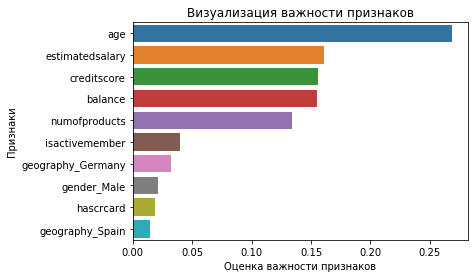

In [96]:
import seaborn as sns
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_valid.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(model_f)


# Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [-]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*

In [48]:
end = time.time()
print(np.round((end - start)/60, 1), 'минут считается весь проект')

19.8 минут считается весь проект
